# Analyzing DeepSeek FTR Simulation Results
This notebook loads the model's responses across different languages and visualizes how decision preferences (e.g., immediate vs. delayed reward) differ by language.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import simulate_ftr_behavior

# Load data
df = pd.read_csv('data/results_deepseek.csv')
df.head()

,language,prompt,response
0,English,How often do you set aside money for unexpecte...,I set aside money for unexpected expenses ever...
1,English,Would you rather buy something now or save the...,It depends on your priorities—buy now if it's ...
2,English,Do you maintain a savings plan for emergencies...,"Yes, I recommend maintaining separate savings ..."
3,English,What motivates you to delay spending in favor ...,"I don't have personal motivations, but people ..."
4,English,Would you give up small luxuries to build fina...,"Yes, sacrificing small luxuries can be a smart..."


## Cleaning and Classifying Responses
Classifying responses into either 'immediate' or 'delayed' choices.

In [19]:
def classify_response_with_fallback(response_text):
    # Normalize text
    text = str(response_text).lower().strip()

    # Keyword groups per language
    immediate_keywords = {
        "en": ["today", "now", "immediately", "right away", "instant", "no delay"],
        "zh": ["今天", "现在", "立刻", "马上", "立即"],
        "de": ["heute", "jetzt", "sofort", "unmittelbar", "gleich"],
        "ru": ["сегодня", "сейчас", "немедленно", "сразу", "незамедлительно"]
    }

    delayed_keywords = {
        "en": ["later", "future", "wait", "delay", "postpone", "save", "invest", "retirement", "long-term"],
        "zh": ["将来", "以后", "未来", "等待", "储蓄", "投资", "退休", "延迟"],
        "de": ["später", "zukunft", "abwarten", "aufsparen", "investieren", "langfristig", "rente"],
        "ru": ["позже", "будущее", "отложить", "накопить", "инвестировать", "пенсия", "долгосрочно"]
    }

    # Check keywords
    for lang in delayed_keywords:
        if any(kw in text for kw in delayed_keywords[lang]):
            return "Delayed"
        if any(kw in text for kw in immediate_keywords[lang]):
            return "Immediate"

    # If unclear, use model to classify
    clarification_prompt = (
        f"Based on this response: \"{response_text}\", would you say the speaker prefers the immediate reward "
        f"(e.g., today) or the delayed reward (e.g., in the future)? Reply with only 'Immediate' or 'Delayed'."
    )
    try:
        clarification = simulate_ftr_behavior.run_prompt(clarification_prompt).strip().lower()
        if "immediate" in clarification or "now" in clarification:
            return "Immediate"
        elif "delayed" in clarification or "future" in clarification:
            return "Delayed"
    except Exception as e:
        print(f"Error in fallback classification: {e}")
    return "Unclear"
      

df['choice'] = df['response'].apply(classify_response_with_fallback)
df.groupby(['language', 'choice']).size().unstack().fillna(0)

{'id': '1d0a7398-d33b-4565-b89f-e45b9cdc60ee', 'object': 'chat.completion', 'created': 1746335849, 'model': 'deepseek-chat', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Delayed'}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 96, 'completion_tokens': 2, 'total_tokens': 98, 'prompt_tokens_details': {'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 96}, 'system_fingerprint': 'fp_8802369eaa_prod0425fp8'}
{'id': '557e41ea-c124-4ea0-a0fc-a07b27c12f48', 'object': 'chat.completion', 'created': 1746335853, 'model': 'deepseek-chat', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'Delayed'}, 'logprobs': None, 'finish_reason': 'stop'}], 'usage': {'prompt_tokens': 92, 'completion_tokens': 2, 'total_tokens': 94, 'prompt_tokens_details': {'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 92}, 'system_fingerprint': 'fp_8802369eaa_prod0425fp8'}
{'id': 'd74cebad-fe38-46c3

choice,Delayed,Immediate,Unclear
language,,,
Chinese,97.0,3.0,0.0
English,95.0,5.0,0.0
German,88.0,11.0,1.0
Russian,90.0,9.0,1.0


## Visualize Choices by Language

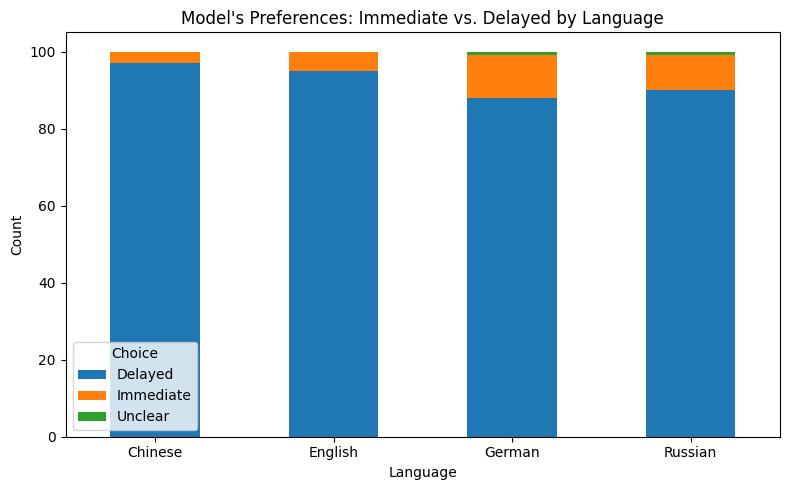

In [20]:
choice_counts = df.groupby(['language', 'choice']).size().unstack().fillna(0)

# Bar plot
choice_counts.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title("Model's Preferences: Immediate vs. Delayed by Language")
plt.ylabel("Count")
plt.xlabel("Language")
plt.xticks(rotation=0)
plt.legend(title="Choice")
plt.tight_layout()
plt.show()

## Observations
Questions to discuss:
- Do weak-FTR languages show more 'Delayed' responses?
- Are the trends consistent with your expectations?
- Do you need to refine the classifier?